In [1]:
import numpy as np
# import sys
import math

import pandas as pd
from sklearn.neighbors import NearestNeighbors

# topk = 10

# Next Basket Recommendation- TIFU-KNN

## 1. Data Preparation and cleaning

In [2]:
df_futures_pd=pd.read_csv(r'C:\destination\tafeng_future.csv')
df_history_pd=pd.read_csv(r'C:\destination\tafeng_history.csv')
data_history1=df_history_pd
data_future1=df_futures_pd

In [3]:
data_history1.head()

,user_id,order_number,product_id
0,1,1,0
1,1,1,1
2,1,1,2
3,1,2,3
4,1,2,4


In [4]:
# data_history1.shape,data_future1.shape

In [5]:
data_history2=pd.DataFrame(data_history1.groupby(['user_id','order_number']).apply(lambda x:list(x['product_id']))).reset_index()
data_history2.rename(columns={0:'Products'},inplace=True)
data_history2.head()

C:\Users\ashis\AppData\Local\Temp\ipykernel_35660\2850081035.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_history2=pd.DataFrame(data_history1.groupby(['user_id','order_number']).apply(lambda x:list(x['product_id']))).reset_index()


,user_id,order_number,Products
0,1,1,"[0, 1, 2]"
1,1,2,"[3, 4, 5, 6, 7]"
2,1,3,[8]
3,1,4,"[9, 10]"
4,1,5,"[11, 12, 6, 13, 14, 15]"


In [6]:
data_history=pd.DataFrame(data_history2.groupby(['user_id']).apply(lambda x:list(x['Products']))).reset_index()
data_history.rename(columns={0:'Products_as_per_txn_order_hist_baskets'},inplace=True)
data_history.head()

C:\Users\ashis\AppData\Local\Temp\ipykernel_35660\4228797489.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_history=pd.DataFrame(data_history2.groupby(['user_id']).apply(lambda x:list(x['Products']))).reset_index()


,user_id,Products_as_per_txn_order_hist_baskets
0,1,"[[0, 1, 2], [3, 4, 5, 6, 7], [8], [9, 10], [11..."
1,2,"[[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, ..."
2,3,"[[148, 149, 122, 150], [151, 152], [151, 153],..."
3,4,"[[173, 174, 175, 176, 177, 178, 179, 180, 181,..."
4,5,"[[227, 228, 229, 50], [230, 231], [232], [233,..."


In [7]:
# Every user should have 1 or the final order in future dataframe
data_future2=pd.DataFrame(data_future1.groupby(['user_id','order_number']).apply(lambda x:list(x['product_id']))).reset_index()
data_future2.rename(columns={0:'Products'},inplace=True)
data_future2.head()

C:\Users\ashis\AppData\Local\Temp\ipykernel_35660\1883075935.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_future2=pd.DataFrame(data_future1.groupby(['user_id','order_number']).apply(lambda x:list(x['product_id']))).reset_index()


,user_id,order_number,Products
0,1,14,"[1144, 3374, 40, 44]"
1,2,16,"[9, 145, 5, 125, 1357, 50]"
2,3,10,"[3771, 1335, 3219, 1965, 7106, 152, 4279]"
3,4,15,"[3551, 361, 4605, 3462, 224]"
4,5,15,"[266, 50, 4919, 40]"


In [8]:
data_future=pd.DataFrame(data_future2.groupby(['user_id']).apply(lambda x:list(x['Products']))).reset_index()
data_future.rename(columns={0:'Products_as_per_txn_order_future_baskets'},inplace=True)
df_gnd_truth=data_future.copy()
data_future.head()

C:\Users\ashis\AppData\Local\Temp\ipykernel_35660\3904488111.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_future=pd.DataFrame(data_future2.groupby(['user_id']).apply(lambda x:list(x['Products']))).reset_index()


,user_id,Products_as_per_txn_order_future_baskets
0,1,"[[1144, 3374, 40, 44]]"
1,2,"[[9, 145, 5, 125, 1357, 50]]"
2,3,"[[3771, 1335, 3219, 1965, 7106, 152, 4279]]"
3,4,"[[3551, 361, 4605, 3462, 224]]"
4,5,"[[266, 50, 4919, 40]]"


In [9]:
print(data_history['user_id'].nunique())
print(data_future['user_id'].nunique())
print(pd.DataFrame(data_history['user_id']).merge(pd.DataFrame(data_future['user_id']),how='inner',on='user_id').shape)

13858
13858
(13858, 1)


In [10]:
df=pd.concat([df_futures_pd,df_history_pd])
df.shape

(571933, 3)

In [11]:
import random
user = list(set(data_future['user_id']))
user_num = len(user)

# random.shuffle(user)
user = [str(user_id) for user_id in user]

train_user = user[:int(user_num*4/5*0.9)]
val_user = user[int(user_num*4/5*0.9):int(user_num*4/5)]
val_user1=val_user
test_user = user[int(user_num*4/5):]

# Assuming each product has been mapped to an individual number , below is the total number of items we have
item_num = max(df['product_id'].tolist())+1

print(f"#Users in train_user: {len(train_user)}\n#Users in val_user:{len(val_user)}\n#Users in test_user:{len(test_user)}\n#Total Products:{item_num},\n#Users in total:{len(user)}")

#Users in train_user: 9977
#Users in val_user:1109
#Users in test_user:2772
#Total Products:11997,
#Users in total:13858


In [12]:
# val_user
# test_user

In [13]:
print(len(val_user))
print(len(test_user))
val_user.extend(test_user)
print(len(val_user))
print(len(set(val_user)))


1109
2772
3881
3881


In [14]:
# len(val_user)

In [15]:
df_hist=data_history[data_history['user_id'].isin([int(x) for x in train_user])].head(100)
# df_fut=data_history[data_history['user_id'].isin([int(x) for x in test_user])]
df_fut=data_history[data_history['user_id'].isin([int(x) for x in val_user])].head(100)
df_hist.shape,df_fut.shape

((100, 2), (100, 2))

In [16]:
df_fut.reset_index(inplace=True,drop=True)
df_hist.reset_index(inplace=True,drop=True)

## 2. Personalized Insights- Feature Engineering

### 2.1. Temporal Ripple Effect

In [17]:
def decayed_wt_assigning(Products_as_per_txn_order,item_num):
    his_list=[]
    records_non_zero=[]
    records_non_zero_values=[]
    # print(f"************* Products_as_per_txn_order : {Products_as_per_txn_order} & \n Total items in database are : {item_num} *************")
    within_decay_rate =0.9
    num_vec=len(Products_as_per_txn_order)
    # print(f"Total number of txns done: {num_vec} ")
    for index in range(len(Products_as_per_txn_order)):
        item_index=Products_as_per_txn_order[index]
        his_vec = np.zeros(item_num)
        # print(f"How old the transaction/Index is: {(num_vec-1)-index} & weight decay values assigned is {within_decay_rate}^{(num_vec-1)-index}")
        decayed_val = np.power(within_decay_rate, (num_vec-1)-index)
        his_vec[item_index]=decayed_val
        # non_zero_indices = his_vec.nonzero() # which indices have non-zero element
        # non_zero_elements = his_vec[non_zero_indices] # what value is present in those non-zero element indexes
        # records_non_zero.append(non_zero_indices)
        # records_non_zero_values.append(non_zero_elements)
        # print(f"his_vec: {non_zero_elements} & non_zero_indices: {non_zero_indices}")
        # print()
        his_list.append(his_vec)
    # print(f"Total length is {len(his_list)} and length of each list is {len(his_list[0])}")
    # print(f"np.sum(np.array(his_list), axis=1).shape: {np.sum(np.array(his_list), axis=0).shape}")
    # print(f"records_non_zero:{records_non_zero} \n\n records_non_zero_values:{records_non_zero_values}\n")
    return his_list,len(his_list)

In [18]:
# decayed_wt_assigning(df_hist.loc[0,'Products_as_per_txn_order_hist_baskets'],item_num)

In [19]:
df_hist.head()

,user_id,Products_as_per_txn_order_hist_baskets
0,1,"[[0, 1, 2], [3, 4, 5, 6, 7], [8], [9, 10], [11..."
1,2,"[[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, ..."
2,3,"[[148, 149, 122, 150], [151, 152], [151, 153],..."
3,4,"[[173, 174, 175, 176, 177, 178, 179, 180, 181,..."
4,5,"[[227, 228, 229, 50], [230, 231], [232], [233,..."


In [20]:
df_hist[['within_decay_rate_list','length']]=df_hist.apply(lambda x:\
                                               decayed_wt_assigning(x['Products_as_per_txn_order_hist_baskets'],item_num),axis=1,result_type='expand')
df_fut[['within_decay_rate_list','length']]=df_fut.apply(lambda x:\
                                             decayed_wt_assigning(x['Products_as_per_txn_order_hist_baskets'],item_num),axis=1,result_type='expand')

In [23]:
df_hist.head()

,user_id,Products_as_per_txn_order_hist_baskets,within_decay_rate_list,length
0,1,"[[0, 1, 2], [3, 4, 5, 6, 7], [8], [9, 10], [11...","[[0.2824295364810001, 0.2824295364810001, 0.28...",13
1,2,"[[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15
2,3,"[[148, 149, 122, 150], [151, 152], [151, 153],...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9
3,4,"[[173, 174, 175, 176, 177, 178, 179, 180, 181,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",14
4,5,"[[227, 228, 229, 50], [230, 231], [232], [233,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",14


In [63]:
df_fut.head()

,user_id,Products_as_per_txn_order_hist_baskets,within_decay_rate_list,length
0,10045,"[[110, 1894, 1532, 168, 6783, 5087, 1441, 50, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2
1,10046,"[[2471, 1169, 6647, 732, 491, 5823, 390, 99, 1...","[[0.0, 0.0, 0.0, 0.0, 0.81, 0.0, 0.0, 0.0, 0.0...",3
2,10047,"[[2172, 7461, 1186, 9474, 1743, 8229, 8568, 38...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",7
3,10048,"[[4274, 9, 2588, 2251, 17, 1245, 6524, 7574, 8...","[[0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2
4,10049,"[[1356, 1910, 144, 1743], [8071, 1356, 3113, 2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3


In [24]:
gp_size=7
df_hist['Group_size']=gp_size
df_hist['Approx_number_of_group']=df_hist['length']/df_hist['Group_size']
df_hist['Residual']=df_hist['Approx_number_of_group']-df_hist['Group_size']
df_hist['Flag']=df_hist.apply(lambda x:1 if ((x['length']%x['Group_size']==0 ) & (x['length']>=x['Group_size'])) else \
                              (2 if (x['length']<x['Group_size']) else 3),axis=1)
# ----------------------------------------------------------------------------------------------------------
df_fut['Group_size']=gp_size
df_fut['Approx_number_of_group']=df_fut['length']/df_fut['Group_size']
df_fut['Residual']=df_fut['Approx_number_of_group']-df_fut['Group_size']
df_fut['Flag']=df_fut.apply(lambda x:1 if ((x['length']%x['Group_size']==0 ) & (x['length']>=x['Group_size'])) else \
                              (2 if (x['length']<x['Group_size']) else 3),axis=1)
# Flag 1 ==> no of transactions are exactly divisible by number of group
# Flag 2 ==> no of transactions is less than  number of group
# Flag 3 ==> no of transactions are not divisible by number of group

In [30]:
# 13,3,14
df_hist[df_hist['length']==3].head()

,user_id,Products_as_per_txn_order_hist_baskets,within_decay_rate_list,length,Group_size,Approx_number_of_group,Residual,Flag
44,46,"[[1194, 2259, 2260, 2261, 56, 2262, 2263, 2264...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3,7,0.428571,-6.571429,2
97,102,"[[365, 1293, 3902, 469, 331, 1856, 3903, 2415,...","[[0.0, 0.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",3,7,0.428571,-6.571429,2


In [27]:
# Flag 1 ==> no of transactions are exactly divisible by number of group
# Flag 2 ==> no of transactions is less than  number of group
# Flag 3 ==> no of transactions are not divisible by number of group

In [28]:
# df_hist.head()

In [29]:
df_hist[df_hist['length']>=7]

,user_id,Products_as_per_txn_order_hist_baskets,within_decay_rate_list,length,Group_size,Approx_number_of_group,Residual,Flag
0,1,"[[0, 1, 2], [3, 4, 5, 6, 7], [8], [9, 10], [11...","[[0.2824295364810001, 0.2824295364810001, 0.28...",13,7,1.857143,-5.142857,3
1,2,"[[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15,7,2.142857,-4.857143,3
2,3,"[[148, 149, 122, 150], [151, 152], [151, 153],...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9,7,1.285714,-5.714286,3
3,4,"[[173, 174, 175, 176, 177, 178, 179, 180, 181,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",14,7,2.000000,-5.000000,1
4,5,"[[227, 228, 229, 50], [230, 231], [232], [233,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",14,7,2.000000,-5.000000,1
...,...,...,...,...,...,...,...,...
91,95,"[[50, 1181, 2858], [3659, 3660], [3661], [3662...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",10,7,1.428571,-5.571429,3
92,96,"[[64, 60, 51, 1110], [3274], [50, 3677], [19],...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",11,7,1.571429,-5.428571,3
95,99,"[[1553], [279, 1116, 3481, 469, 2710], [1382, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",31,7,4.428571,-2.571429,3
96,100,"[[2921, 613, 701, 3258, 1397, 1901, 410, 2664,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",42,7,6.000000,-1.000000,1


### 2.2. Temporal Fracture Effect

In [52]:
import math

def grouping_txns_into_gp_size(within_decay_rate_list,flag):
    if flag==1:
        # print(f"Number of transactions : {len(within_decay_rate_list)} to be divided into {gp_size} groups")
        all_txns_array=np.array(within_decay_rate_list)
        # print(f"all_txns_array.shape : {all_txns_array.shape}")

        all_txns_array1=all_txns_array.reshape(gp_size,-1,len(within_decay_rate_list[0]))
        # print(f"all_txns_array1.shape : {all_txns_array1.shape} and individual shape is : {all_txns_array1.shape[0]} , {all_txns_array1.shape[1]}, {all_txns_array1.shape[2]}")
        # print(f"To be normalised on {all_txns_array1.shape[1]}")
        group_sums = np.sum(all_txns_array1, axis=1)/ all_txns_array1.shape[1]
        group_sums=group_sums.reshape(gp_size,1,-1)
        # print(f"group_sums after Addition and Normalisation are {group_sums.shape}")

        return group_sums,group_sums.shape[0]
    elif flag==2:
        group_sums=np.array(within_decay_rate_list).reshape(len(within_decay_rate_list),1,-1)
        # print(f"group_sums:{group_sums}")
        # print(f"Length of within_decay_rate_list is:{len(within_decay_rate_list)} & group_sums.shape: {group_sums.shape}")

        return group_sums,group_sums.shape[0]
    elif flag==3:
        est_num_vec_each_block = len(within_decay_rate_list)/gp_size
        base_num_vec_each_block = int(np.floor(len(within_decay_rate_list)/gp_size))
        residual = est_num_vec_each_block - base_num_vec_each_block
        num_vec_has_extra_vec = int(np.round(residual * gp_size))
        # print(f"est_num_vec_each_block:{est_num_vec_each_block}")
        # print(f"base_num_vec_each_block:{base_num_vec_each_block}")
        # print(f"residual:{residual}")
        # print(f"num_vec_has_extra_vec:{num_vec_has_extra_vec}")

        first_few_groups=gp_size-num_vec_has_extra_vec
        # print(f"first_few_groups:{first_few_groups} where each group should have {base_num_vec_each_block} elements")
        total_no_elements_first_few_gps=first_few_groups*base_num_vec_each_block
        # print(f"total_no_elements_first_few_gps:{total_no_elements_first_few_gps}")
        # print(f"within_decay_rate_list:{np.array(within_decay_rate_list).shape}")
        all_txns_array_first_few=np.array(within_decay_rate_list[:total_no_elements_first_few_gps])
        all_txns_array_first_few1=all_txns_array_first_few.reshape(first_few_groups,-1,item_num)
        # print(all_txns_array_first_few1.shape)
        all_txns_array_first_few2=np.sum(all_txns_array_first_few1,axis=1)/base_num_vec_each_block
        # print(all_txns_array_first_few2.shape)

        est_num = int(np.ceil(est_num_vec_each_block))
        # print(f"est_num:{est_num}")
        all_txns_array_rest=np.array(within_decay_rate_list[total_no_elements_first_few_gps:])
        # print(f"all_txns_array_rest:{all_txns_array_rest.shape}")
        numbers_of_gps_left=gp_size-first_few_groups
        # print(f"numbers_of_gps_left to be created :{numbers_of_gps_left} and divide {est_num} elements")
        all_txns_array_rest_left=all_txns_array_rest.reshape(numbers_of_gps_left,-1,item_num)
        # print(all_txns_array_rest_left.shape)
        all_txns_array_rest_left2=np.sum(all_txns_array_rest_left,axis=1)/est_num
        # print(f"all_txns_array_rest_left2:{all_txns_array_rest_left2.shape}")
        final_arrays=np.concatenate((all_txns_array_first_few2,all_txns_array_rest_left2),axis=0).reshape(-1,1,item_num)
        # print(f"final_arrays:{final_arrays.shape}")
        return final_arrays,final_arrays.shape[0]

In [44]:
df_hist.loc[df_hist['user_id']==2]['Flag'].values[0]

In [48]:
# 2=Flag 3
# 4=Flag=1
# 7=Flag=2
uid=2
final_arrays,_=grouping_txns_into_gp_size(df_hist.loc[df_hist['user_id']==uid]['within_decay_rate_list'].values[0],df_hist.loc[df_hist['user_id']==uid]['Flag'].values[0])

Flag 3 ==> no of transactions are not divisible by number of group... where length of txns is 15 & gp_size:7
est_num_vec_each_block:2.142857142857143
base_num_vec_each_block:2
residual:0.1428571428571428
num_vec_has_extra_vec:1
first_few_groups:6 where each group should have 2 elements
total_no_elements_first_few_gps:12
within_decay_rate_list:(15, 11997) 
(6, 2, 11997) 
 [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
To be normalised on 2
---------> (6, 11997) <---------
est_num:3
all_txns_array_rest:(3, 11997)
numbers_of_gps_left to be created :1 and in each group we will have  3 transactions
(1, 3, 11997) 
 [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
To be normalised on 3
----

In [53]:
df_hist[['txns_into_gp_size','condensed_length']]=df_hist.apply(lambda x:grouping_txns_into_gp_size(
    x['within_decay_rate_list'],x['Flag']),axis=1,result_type='expand')

df_fut[['txns_into_gp_size','condensed_length']]=df_fut.apply(lambda x:grouping_txns_into_gp_size(
    x['within_decay_rate_list'],x['Flag']),axis=1,result_type='expand')


In [57]:
df_hist[df_hist['condensed_length']==4]

,user_id,Products_as_per_txn_order_hist_baskets,within_decay_rate_list,length,Group_size,Approx_number_of_group,Residual,Flag,txns_into_gp_size,condensed_length
6,7,"[[110, 305, 306, 218, 307], [308, 309, 310, 31...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4,7,0.571429,-6.428571,2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",4
36,37,"[[1901, 1175, 1902, 1903, 1408, 181, 1746, 143...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4,7,0.571429,-6.428571,2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",4
43,45,"[[469, 174, 2247, 1462, 2248, 2249, 1256, 198,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4,7,0.571429,-6.428571,2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",4
56,58,"[[674, 2663, 347, 2664, 2665, 209, 2666], [266...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4,7,0.571429,-6.428571,2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",4
57,59,"[[880, 50], [1098, 2676], [2676, 2677, 1414, 2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4,7,0.571429,-6.428571,2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",4
68,71,"[[3135], [3136, 3137, 3138], [2545, 3139, 3140...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4,7,0.571429,-6.428571,2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",4
76,80,"[[1330, 3312, 2766, 3313, 2917, 2717, 468, 613...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4,7,0.571429,-6.428571,2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",4


### 2.3. group_decay_list

In [70]:
def group_decay_list(Group_Decay_list,flag):
  group_decay_rate = 0.7
  # Define the list
  # print(f"Sum: {sum(Group_Decay_list[0].nonzero())},{sum(Group_Decay_list[1].nonzero())}")

  # print(f"Group_Decay_list:{Group_Decay_list.shape}")
  # print(f"Group_Decay_list: {Group_Decay_list}")
  # print(Group_Decay_list[::-1][0].nonzero(),Group_Decay_list[::-1][1].nonzero(),Group_Decay_list[::-1][2].nonzero())
  # print(Group_Decay_list[::-1][0][Group_Decay_list[::-1][0].nonzero()],Group_Decay_list[::-1][1][Group_Decay_list[::-1][1].nonzero()],Group_Decay_list[::-1][2][Group_Decay_list[::-1][2].nonzero()])

  rev_sorted_list_np = Group_Decay_list[::-1].reshape(len(Group_Decay_list),1,-1)
  # print(f"rev_sorted_list_np: \n{rev_sorted_list_np.shape}")
  # print(rev_sorted_list_np[::-1][0][rev_sorted_list_np[::-1][0].nonzero()],rev_sorted_list_np[::-1][1][rev_sorted_list_np[::-1][1].nonzero()],rev_sorted_list_np[::-1][2][rev_sorted_list_np[::-1][2].nonzero()])
  if flag==2:
    group_decay_array=np.array([group_decay_rate**x for x in range(gp_size)][-len(rev_sorted_list_np):]).reshape(len(rev_sorted_list_np), 1, 1)
  else:
    group_decay_array=np.array([group_decay_rate**x for x in range(len(rev_sorted_list_np))]).reshape(len(rev_sorted_list_np), 1, 1)
  # print(f"group_decay_array:\n {group_decay_array.shape} & {group_decay_array}")
  result = rev_sorted_list_np * group_decay_array
  # print(f"result.shape: {result.shape} & result is \n {result[result.nonzero()]}")
  after_summingup=np.sum(result,axis=0)
  # print(f"After summin up result.shape: {after_summingup.shape} & result is \n {after_summingup[after_summingup.nonzero()]}")

  result_sum=np.sum(result,axis=0)/result.shape[0]
  # print(f"result_sum.shape: {result_sum.shape}")
  # print(f"result_sum non zero: {result_sum.nonzero()}")
  # print(f"result_sum non zero values: {result_sum[result_sum.nonzero()]}")

  return result,result_sum[0]

In [73]:
df_hist[['Group_Decay_list','Final_list_vectors']]=df_hist.apply(lambda x:group_decay_list(x['txns_into_gp_size'],x['Flag']),axis=1,result_type='expand')
df_fut[['Group_Decay_list','Final_list_vectors']]=df_fut.apply(lambda x:group_decay_list(x['txns_into_gp_size'],x['Flag']),axis=1,result_type='expand')
# df_hist.head()

In [74]:
df_hist.head()

,user_id,Products_as_per_txn_order_hist_baskets,within_decay_rate_list,length,Group_size,Approx_number_of_group,Residual,Flag,txns_into_gp_size,condensed_length,Group_Decay_list,Final_list_vectors
0,1,"[[0, 1, 2], [3, 4, 5, 6, 7], [8], [9, 10], [11...","[[0.2824295364810001, 0.2824295364810001, 0.28...",13,7,1.857143,-5.142857,3,"[[[0.2824295364810001, 0.2824295364810001, 0.2...",7,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.004746793219636168, 0.004746793219636168, 0..."
1,2,"[[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15,7,2.142857,-4.857143,3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",7,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.00664426138635, 0.0, 0...."
2,3,"[[148, 149, 122, 150], [151, 152], [151, 153],...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9,7,1.285714,-5.714286,3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",7,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,"[[173, 174, 175, 176, 177, 178, 179, 180, 181,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",14,7,2.000000,-5.000000,1,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",7,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.03645, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
4,5,"[[227, 228, 229, 50], [230, 231], [232], [233,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",14,7,2.000000,-5.000000,1,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",7,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
df_hist[['user_id','Products_as_per_txn_order_hist_baskets','within_decay_rate_list','Group_Decay_list','Final_list_vectors']].head()

,user_id,Products_as_per_txn_order_hist_baskets,within_decay_rate_list,Group_Decay_list,Final_list_vectors
0,1,"[[0, 1, 2], [3, 4, 5, 6, 7], [8], [9, 10], [11...","[[0.2824295364810001, 0.2824295364810001, 0.28...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18849857142...","[0.004746793219636168, 0.004746793219636168, 0..."
1,2,"[[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.00664426138635, 0.0, 0...."
2,3,"[[148, 149, 122, 150], [151, 152], [151, 153],...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,"[[173, 174, 175, 176, 177, 178, 179, 180, 181,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.03645, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
4,5,"[[227, 228, 229, 50], [230, 231], [232], [233,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [76]:
df_hist_final_set=df_hist[['user_id','Final_list_vectors']]
df_fut_final_set=df_fut[['user_id','Final_list_vectors']]
history_mat=df_hist_final_set['Final_list_vectors'].values
test_mat=df_fut_final_set['Final_list_vectors'].values

In [47]:
df_hist_final_set.head()

,user_id,Final_list_vectors
0,1,"[0.004746793219636168, 0.004746793219636168, 0..."
1,2,"[0.0, 0.0, 0.0, 0.0, 0.00664426138635, 0.0, 0...."
2,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,"[0.0, 0.03645, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
4,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [48]:
df_fut_final_set.head()

,user_id,Final_list_vectors
0,10045,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.084..."
1,10046,"[0.0, 0.0, 0.0, 0.0, 0.03176522999999999, 0.0,..."
2,10047,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,10048,"[0.052942049999999984, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,10049,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## 3. KNN part - Collaborative filtering 

In [77]:
l1_hist=[]
for x in history_mat:
  l1_hist.append(x)
print(len(l1_hist))
l1_fut=[]
for x in test_mat:
  l1_fut.append(x)
print(len(l1_fut))


100
100


In [78]:
dict_fut=dict(zip(df_fut_final_set['user_id'],df_fut_final_set['Final_list_vectors']))
dict_hist=dict(zip(df_hist_final_set['user_id'],df_hist_final_set['Final_list_vectors']))

In [79]:
# dict_fut[11092].nonzero()

In [80]:
len(l1_hist),len(l1_fut)

(100, 100)

In [81]:
# num_nearest_neighbors = 300
num_nearest_neighbors = 5
nbrs = NearestNeighbors(n_neighbors=num_nearest_neighbors, algorithm='brute').fit(l1_hist)
distances, indices = nbrs.kneighbors(l1_fut)

In [82]:
distances.shape, indices.shape

((100, 5), (100, 5))

In [83]:
indices[0]

array([60, 26, 95, 69, 49], dtype=int64)

In [84]:
dict_mapping_nearest_neighbors={df_fut_final_set['user_id'].values[i]:indices[i] for i in range(len(indices))}
dict_mapping_nearest_neighbors

{10045: array([60, 26, 95, 69, 49], dtype=int64),
 10046: array([69, 95, 49, 26, 10], dtype=int64),
 10047: array([95, 69, 49, 10, 26], dtype=int64),
 10048: array([95, 49, 69, 26, 10], dtype=int64),
 10049: array([69, 95, 49, 26, 10], dtype=int64),
 10050: array([69, 95, 49, 26, 10], dtype=int64),
 10051: array([69, 60, 95, 49, 26], dtype=int64),
 10052: array([95, 26, 69, 49, 10], dtype=int64),
 10053: array([95, 71, 49, 69, 26], dtype=int64),
 10054: array([26, 49, 69, 95, 10], dtype=int64),
 10055: array([26, 49, 69, 95, 40], dtype=int64),
 10056: array([69, 95, 49, 26, 10], dtype=int64),
 10057: array([69, 95, 49, 26, 10], dtype=int64),
 10058: array([49, 69, 26, 95, 60], dtype=int64),
 10059: array([69, 95, 49, 26, 10], dtype=int64),
 10060: array([71, 69, 95, 49, 26], dtype=int64),
 10061: array([69, 95, 49, 26, 10], dtype=int64),
 10062: array([95, 69, 49, 26, 71], dtype=int64),
 10063: array([60, 69, 49, 26, 73], dtype=int64),
 10064: array([69, 95, 26, 49, 10], dtype=int64),


In [57]:
dict_mapping_nearest_neighbors[10106]

array([69, 95, 49, 26, 10], dtype=int64)

## 4. Final Predictions

In [91]:
# def final_recommendation(user_id):
#   alpha = 0.7
#   top_k=20
#   # print(f"***************************** Test set vectors for userid={user_id} ****************************************")
#   test_set_vectors=df_fut_final_set.loc[df_fut_final_set['user_id']==user_id,'Final_list_vectors'].tolist()[0]
#   test_set_vectors=test_set_vectors.reshape(1,-1)
#   # print(f"{test_set_vectors.shape} & {test_set_vectors[test_set_vectors.nonzero()]}")
#   # print(f"***************************** Train set vectors coming from collaborative filtering ****************************************")
#   NN_for_user_in_test_set=dict_mapping_nearest_neighbors[user_id]
#   # print(f"Length of users from collaborative filtering i.e. Top {indices.shape[1]} users recommended : {len(NN_for_user_in_test_set)},{(NN_for_user_in_test_set)}")
#   np_array_train_set = np.array(df_hist_final_set[df_hist_final_set.index.isin(NN_for_user_in_test_set)]['Final_list_vectors'].tolist())
#   # print(f"Corresponding to each user we have {item_num} products coming as a recommendation : {np_array_train_set.shape}")
#   sum_shape_final=np.sum(np_array_train_set.reshape(indices.shape[1],-1,item_num),axis=0)/indices.shape[1]
#   # print(f"sum_shape_final:{sum_shape_final[sum_shape_final.nonzero()]}")
#   # print(f"Combining all the {len(NN_for_user_in_test_set)} user's recommendation into 1, we have got: {sum_shape_final.shape}")
#   # print(f"*******************************Combined*******************************************")
#   # print("Giving weightage to test_set_vectors and collaborative vectors ")
#   # print(f"{alpha} * test_set_vectors + (1-{alpha})*collaborative_vectors")
#   combined=alpha * test_set_vectors + (1-alpha)*sum_shape_final
#   # print(len(combined[0]),combined,combined.shape, combined.argsort()[::-1].shape)
#   # print(f"Combined sort: {np.sort(combined)[::-1]}")
#   # label_list = combined.argsort()[::-1].tolist()
#   label_list = combined[0].argsort()[::-1].reshape(-1,)[:top_k]
#   # print(f"Out of the {item_num} items , we recommend the {top_k} items at position {label_list} to the user: {user_id}")
#   return label_list.tolist()

In [119]:
def final_recommendation(user_id):
  alpha = 0.7
  top_k=20
  print(f"***************************** From Personalized insights  POV: Test set vectors for userid={user_id} ****************************************")
  test_set_vectors=df_fut_final_set.loc[df_fut_final_set['user_id']==user_id,'Final_list_vectors'].tolist()[0]
  test_set_vectors=test_set_vectors.reshape(1,-1)
  print(f"{test_set_vectors.shape} & {test_set_vectors[test_set_vectors.nonzero()]}")
  print(f"***************************** Train set vectors coming from collaborative filtering ****************************************")
  NN_for_user_in_test_set=dict_mapping_nearest_neighbors[user_id]
  print(f"Length of users from collaborative filtering i.e. Top {indices.shape[1]} users recommended : {len(NN_for_user_in_test_set)},{(NN_for_user_in_test_set)}")
  np_array_train_set = np.array(df_hist_final_set[df_hist_final_set.index.isin(NN_for_user_in_test_set)]['Final_list_vectors'].tolist())
  print(f"Corresponding to each user we have {item_num} products coming as a recommendation : {np_array_train_set.shape}")
  sum_shape_final=np.sum(np_array_train_set.reshape(indices.shape[1],-1,item_num),axis=0)/indices.shape[1]
  # print(f"sum_shape_final:{sum_shape_final[sum_shape_final.nonzero()]}")
  print(f"Combining all the {len(NN_for_user_in_test_set)} user's recommendation into 1, we have got: {sum_shape_final.shape}")
  print(f"*******************************Combined*******************************************")
  print("Giving weightage to Personalized Profile vectors and collaborative vectors ")
  print(f"{alpha} * Personalized Profile vectors + (1-{alpha})*collaborative_vectors")
  combined=alpha * test_set_vectors + (1-alpha)*sum_shape_final
  # print(combined.shape,combined)
  # print(len(combined[0]),combined,combined.shape, combined.argsort()[::-1].shape)
  print(f"Combined sort: {np.sort(combined)[::-1]}")
  label_list = combined.argsort()[::-1].tolist()
  label_list = combined[0].argsort()[::-1].reshape(-1,)[:top_k]
  print(f"Out of the {item_num} items , we recommend the {top_k} items at position {label_list} to the user: {user_id}")
  return label_list.tolist()

In [118]:
# print(10106)
final_recommendation(10106)
# # final_recommendation(11230)

***************************** From Personalized insights  POV: Test set vectors for userid=10106 ****************************************
(1, 11997) & [0.03176523 0.03176523 0.03176523 0.03176523 0.03176523 0.050421
 0.08003333 0.050421   0.03176523 0.050421   0.050421   0.050421
 0.050421   0.050421   0.050421   0.08003333 0.050421   0.050421  ]
***************************** Train set vectors coming from collaborative filtering ****************************************
Length of users from collaborative filtering i.e. Top 5 users recommended : 5,[69 95 49 26 10]
Corresponding to each user we have 11997 products coming as a recommendation : (5, 11997)
Combining all the 5 user's recommendation into 1, we have got: (1, 11997)
*******************************Combined*******************************************
Giving weightage to Personalized Profile vectors and collaborative vectors 
0.7 * Personalized Profile vectors + (1-0.7)*collaborative_vectors
(1, 11997) [[0.0000000e+00 2.2358007e-06 

[556,
 8843,
 717,
 2377,
 4564,
 5697,
 827,
 11235,
 544,
 4290,
 818,
 10366,
 4,
 368,
 145,
 491,
 235,
 797,
 723,
 50]

In [121]:
df_fut_final_set['Final_Recommendation']=df_fut_final_set.apply(lambda x:final_recommendation(x['user_id']),axis=1)

***************************** From Personalized insights  POV: Test set vectors for userid=10045 ****************************************
(1, 11997) & [0.084035   0.05294205 0.05294205 0.084035   0.05294205 0.05294205
 0.084035   0.084035   0.084035   0.084035   0.084035   0.084035
 0.084035   0.05294205 0.05294205 0.05294205 0.084035   0.084035
 0.05294205 0.05294205 0.05294205 0.084035   0.05294205 0.084035
 0.084035   0.05294205 0.05294205 0.05294205 0.084035   0.084035
 0.084035   0.084035   0.084035   0.084035   0.05294205 0.05294205
 0.05294205 0.05294205 0.084035   0.084035  ]
***************************** Train set vectors coming from collaborative filtering ****************************************
Length of users from collaborative filtering i.e. Top 5 users recommended : 5,[60 26 95 69 49]
Corresponding to each user we have 11997 products coming as a recommendation : (5, 11997)
Combining all the 5 user's recommendation into 1, we have got: (1, 11997)
*************************

C:\Users\ashis\AppData\Local\Temp\ipykernel_35660\256555032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fut_final_set['Final_Recommendation']=df_fut_final_set.apply(lambda x:final_recommendation(x['user_id']),axis=1)


In [134]:
df_fut_final_set.head()

,user_id,Final_list_vectors,Final_Recommendation
0,10045,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.084...","[401, 135, 8, 1592, 2845, 2846, 396, 4753, 496..."
1,10046,"[0.0, 0.0, 0.0, 0.0, 0.03176522999999999, 0.0,...","[719, 1203, 699, 187, 4506, 11357, 1743, 9754,..."
2,10047,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[45, 3706, 6549, 182, 2798, 767, 126, 1099, 79..."
3,10048,"[0.052942049999999984, 0.0, 0.0, 0.0, 0.0, 0.0...","[1309, 6537, 3299, 2847, 137, 2027, 719, 1592,..."
4,10049,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1356, 3113, 5136, 8717, 2345, 8071, 144, 1743..."


In [135]:
df_fut_final_set.columns,df_gnd_truth.columns

(Index(['user_id', 'Final_list_vectors', 'Final_Recommendation'], dtype='object'),
 Index(['user_id', 'Products_as_per_txn_order_future_baskets'], dtype='object'))

In [136]:
df_gnd_truth['Grnd_Truth_unlist']=df_gnd_truth['Products_as_per_txn_order_future_baskets'].apply(lambda x:x[0])

In [137]:
df_fut_final_set.head()

,user_id,Final_list_vectors,Final_Recommendation
0,10045,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.084...","[401, 135, 8, 1592, 2845, 2846, 396, 4753, 496..."
1,10046,"[0.0, 0.0, 0.0, 0.0, 0.03176522999999999, 0.0,...","[719, 1203, 699, 187, 4506, 11357, 1743, 9754,..."
2,10047,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[45, 3706, 6549, 182, 2798, 767, 126, 1099, 79..."
3,10048,"[0.052942049999999984, 0.0, 0.0, 0.0, 0.0, 0.0...","[1309, 6537, 3299, 2847, 137, 2027, 719, 1592,..."
4,10049,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1356, 3113, 5136, 8717, 2345, 8071, 144, 1743..."


In [138]:
df_final_analysis_tbd=df_fut_final_set[['user_id','Final_Recommendation']].\
merge(df_gnd_truth[['user_id','Grnd_Truth_unlist']],how='inner',on='user_id').\
merge(df_fut,how='inner',on='user_id')

In [139]:
df_final_analysis_tbd.head()

,user_id,Final_Recommendation,Grnd_Truth_unlist,Products_as_per_txn_order_hist_baskets,within_decay_rate_list,length,Group_size,Approx_number_of_group,Residual,Flag,txns_into_gp_size,condensed_length,Group_Decay_list,Final_list_vectors
0,10045,"[401, 135, 8, 1592, 2845, 2846, 396, 4753, 496...","[3955, 1366, 952, 4716, 1926, 2152, 1882, 1168...","[[110, 1894, 1532, 168, 6783, 5087, 1441, 50, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2,7,0.285714,-6.714286,2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.084..."
1,10046,"[719, 1203, 699, 187, 4506, 11357, 1743, 9754,...","[1447, 1203, 119]","[[2471, 1169, 6647, 732, 491, 5823, 390, 99, 1...","[[0.0, 0.0, 0.0, 0.0, 0.81, 0.0, 0.0, 0.0, 0.0...",3,7,0.428571,-6.571429,2,"[[[0.0, 0.0, 0.0, 0.0, 0.81, 0.0, 0.0, 0.0, 0....",3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.03176522999999999, 0.0,..."
2,10047,"[45, 3706, 6549, 182, 2798, 767, 126, 1099, 79...","[4136, 3685, 509, 50, 1034, 828, 1826, 421, 44...","[[2172, 7461, 1186, 9474, 1743, 8229, 8568, 38...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",7,7,1.000000,-6.000000,1,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",7,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,10048,"[1309, 6537, 3299, 2847, 137, 2027, 719, 1592,...","[2808, 491, 2542, 6708, 1347, 469, 9375, 9876,...","[[4274, 9, 2588, 2251, 17, 1245, 6524, 7574, 8...","[[0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2,7,0.285714,-6.714286,2,"[[[0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.052942049999999984, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,10049,"[1356, 3113, 5136, 8717, 2345, 8071, 144, 1743...",[5548],"[[1356, 1910, 144, 1743], [8071, 1356, 3113, 2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3,7,0.428571,-6.571429,2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [128]:
# df_final_analysis_tbd['Historical_one_list']=df_final_analysis_tbd['Products_as_per_txn_order_hist_baskets'].apply(lambda x:[item for sublist in x for item in sublist] )
# df_final_analysis_tbd.head()

## 5. Metric on the basis of which we judge the quality of Model 

### Recall

In [71]:

def func_recall(actual,pred):
    Overlap_cnts=len([x for x in pred if x in actual])
    total_cnts=len(actual)
    recall=Overlap_cnts/total_cnts
    return recall
df_final_analysis_tbd['Recall']=df_final_analysis_tbd.apply(lambda x:func_recall(x['Grnd_Truth_unlist'],x['Final_Recommendation']),axis=1)

### NDCG

In [72]:
import math

In [73]:
def func_ndcg(actual,pred):
    index_posns_nr=[pred.index(i)+1 for i in pred if i in actual]
    numerator=sum([(1/math.log2(x+1)) for x in index_posns_nr])
#     print(numerator)
    ranges=min(len(actual),len(pred))

    if ranges==len(pred):
        index_posns_dr=[pred.index(i)+1 for i in pred]
#         print(index_posns_dr)
        denominator=sum([1/math.log2(x+1) for x in index_posns_dr])
#         print(denominator)
    if ranges==len(actual):
        index_posns_dr=[actual.index(i)+1 for i in actual]
#         print(index_posns_dr)
        denominator=sum([1/math.log2(x+1) for x in index_posns_dr])
#         print(denominator)
    ndcg=numerator/denominator
    return ndcg

In [74]:
df_final_analysis_tbd['Ndcg']=df_final_analysis_tbd.apply(lambda x:func_ndcg(x['Grnd_Truth_unlist'],x['Final_Recommendation']),axis=1)

### Personalized Hit Ratio

In [75]:
def func_phr(actual,pred):
    return int(any([x for x in pred if x in actual]))

In [76]:

df_final_analysis_tbd['PHR']=df_final_analysis_tbd.apply(lambda x:func_phr(x['Grnd_Truth_unlist'],x['Final_Recommendation']),axis=1)
df_final_analysis_tbd.head()

,user_id,Final_Recommendation,Grnd_Truth_unlist,Products_as_per_txn_order_hist_baskets,within_decay_rate_list,length,Group_size,Approx_number_of_group,Residual,Flag,txns_into_gp_size,condensed_length,Group_Decay_list,Final_list_vectors,Historical_one_list,Recall,Ndcg,PHR
0,10045,"[401, 135, 8, 1592, 2845, 2846, 396, 4753, 496...","[3955, 1366, 952, 4716, 1926, 2152, 1882, 1168...","[[110, 1894, 1532, 168, 6783, 5087, 1441, 50, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2,7,0.285714,-6.714286,2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.084...","[110, 1894, 1532, 168, 6783, 5087, 1441, 50, 2...",0.000000,0.000000,0
1,10046,"[719, 1203, 699, 187, 4506, 11357, 1743, 9754,...","[1447, 1203, 119]","[[2471, 1169, 6647, 732, 491, 5823, 390, 99, 1...","[[0.0, 0.0, 0.0, 0.0, 0.81, 0.0, 0.0, 0.0, 0.0...",3,7,0.428571,-6.571429,2,"[[[0.0, 0.0, 0.0, 0.0, 0.81, 0.0, 0.0, 0.0, 0....",3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.03176522999999999, 0.0,...","[2471, 1169, 6647, 732, 491, 5823, 390, 99, 10...",0.333333,0.296082,1
2,10047,"[45, 3706, 6549, 182, 2798, 767, 126, 1099, 79...","[4136, 3685, 509, 50, 1034, 828, 1826, 421, 44...","[[2172, 7461, 1186, 9474, 1743, 8229, 8568, 38...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",7,7,1.000000,-6.000000,1,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",7,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2172, 7461, 1186, 9474, 1743, 8229, 8568, 386...",0.142857,0.088732,1
3,10048,"[1309, 6537, 3299, 2847, 137, 2027, 719, 1592,...","[2808, 491, 2542, 6708, 1347, 469, 9375, 9876,...","[[4274, 9, 2588, 2251, 17, 1245, 6524, 7574, 8...","[[0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2,7,0.285714,-6.714286,2,"[[[0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.052942049999999984, 0.0, 0.0, 0.0, 0.0, 0.0...","[4274, 9, 2588, 2251, 17, 1245, 6524, 7574, 80...",0.000000,0.000000,0
4,10049,"[1356, 3113, 5136, 8717, 2345, 8071, 144, 1743...",[5548],"[[1356, 1910, 144, 1743], [8071, 1356, 3113, 2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3,7,0.428571,-6.571429,2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1356, 1910, 144, 1743, 8071, 1356, 3113, 2345...",0.000000,0.000000,0


In [77]:
print(f"Avg Recall is :- {df_final_analysis_tbd['Recall'].mean()}")
print(f"Avg Ndcg is :- {df_final_analysis_tbd['Ndcg'].mean()}")
print(f"Avg PHR is:- {df_final_analysis_tbd['PHR'].sum()/df_final_analysis_tbd.shape[0]}")

Avg Recall is :- 0.12904844877344876
Avg Ndcg is :- 0.09972347192587067
Avg PHR is:- 0.44


In [78]:
print(len(test_user))
val_uss1=[item for item in val_user if item not in test_user]

len(val_uss1)

2772


1109

In [79]:
# Val user
df_final_analysis_tbd_test=df_final_analysis_tbd[df_final_analysis_tbd['user_id'].isin([int(x) for x in val_uss1])]
print(df_final_analysis_tbd_test.shape)
print(f"Avg Recall is :- {df_final_analysis_tbd_test['Recall'].mean()}")
print(f"Avg Ndcg is :- {df_final_analysis_tbd_test['Ndcg'].mean()}")
print(f"Avg PHR is:- {df_final_analysis_tbd_test['PHR'].sum()/df_final_analysis_tbd_test.shape[0]}")

(100, 18)
Avg Recall is :- 0.12904844877344876
Avg Ndcg is :- 0.09972347192587067
Avg PHR is:- 0.44


In [80]:

print(df_final_analysis_tbd.shape[0])

100


In [81]:
# df_final_analysis_tbd.head()

In [82]:
# print(df_final_analysis_tbd.columns)

In [ ]:
k=20
df_final_analysis_tbd['common_items_count']=df_final_analysis_tbd.apply(lambda x:len(list(set(x['Historical_one_list']) & set(x['Grnd_Truth_unlist'])))/k,axis=1)

df_final_analysis_tbd['uncommon_items_count']=df_final_analysis_tbd.apply(lambda x:1-x['common_items_count'],axis=1)

print(df_final_analysis_tbd['common_items_count'].mean())
print(df_final_analysis_tbd['uncommon_items_count'].mean())


0.040298892038134505
0.9597011079618654


100

C:\Users\ashis\AppData\Local\Temp\ipykernel_35660\531736715.py:8: RuntimeWarning: divide by zero encountered in divide
  y_values = 1/np.log2(x_values)


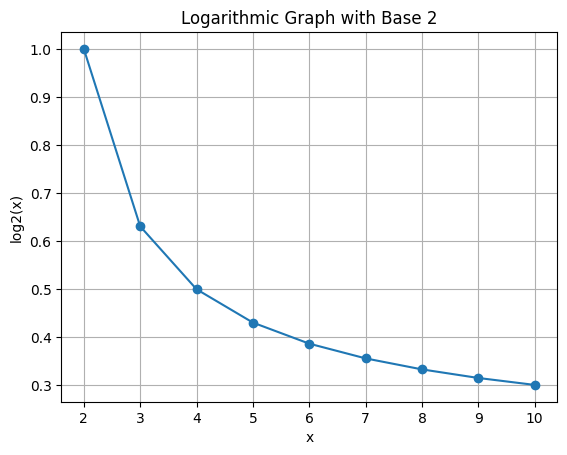

In [127]:

# import numpy as np
# import matplotlib.pyplot as plt

# # Generate x values from 1 to 10
# x_values = np.arange(1, 11)

# # Calculate y values using log base 2
# y_values = 1/np.log2(x_values)

# # Plot the logarithmic function
# plt.plot(x_values, y_values, marker='o', linestyle='-')

# # Add labels and title
# plt.xlabel('x')
# plt.ylabel('log2(x)')
# plt.title('Logarithmic Graph with Base 2')

# # Add grid
# plt.grid(True)

# # Show plot
# plt.show()